# RATING Project

Comic Mischief Detection Task

Files:

1. "train.csv" : 
-- Contains multiclass classification content annotations for each video scene used in the training set.
-- Annotations are on a scene level and do not correspond to a specific modality
-- a ".csv" file containing video URLs as well as the IDs of the scenes used in the training set.
-- Videos are available in the form of URLs, collected from the Youtube and the IMDB websites.
-- Contains metadata about the videos.
-- Four content categories related to comic mischief are used (Sarcasm, Slapstick Humor, Gory Humor, Mature Humor).

2. "val.csv" : 
-- Contains multiclass classification content annotations for each video scene used in the validation set.
-- You can use this set for performing model hyperparameter tuning before using the test set


3. "test.csv" : 
-- Contains multiclass classification content annotations for each video scene used in the test set.
-- You can use this set for evaluating your method

In [1]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
print("device name:", device_name)

tf.test.is_gpu_available()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9450492312340943968
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6302793728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14293800770463999415
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5"
]
2.6.0
Num GPUs Available:  1
device name: /device:GPU:0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.test.is_built_with_gpu_support()

True

In [5]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:02:00.0, compute capability: 7.5



In [6]:
# global variables

train_dir = os.getcwd() + "/train_data/"
val_dir = os.getcwd() + "/val_data/"
test_dir = os.getcwd() + "/test_data/"

# Hyperparameters
MAX_SEQ_LENGTH = 1440
NUM_FEATURES = 1024
IMG_SIZE = 224

EPOCHS = 20
BATCH_SIZE = 64

### References
1. https://keras.io/examples/vision/video_transformers/)
2. https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub)
3. https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb

## Data Preparation (not complete)

### METADATA loading

In [7]:
# Create a dataframe which contains multiclass classification content annotations for each video scene used in the training set.
train_df = pd.read_csv('train-updated.csv', dtype={'combination': object}).iloc[:,1:]
train_df["path"] = train_dir + train_df["Video ID"]+ ".0" + train_df["Scene_ID"].astype(str) + ".mp4"
train_df.head()

,Video ID,Scene_ID,Video URL,Codec,Resolution,Avg Frame rate,Mature Humor - Scene Annotation,Slapstick Humor - Scene Annotation,Gory Humor - Scene Annotation,Sarcasm - Scene Annotation,combination,path
0,tt2872718,0,https://www.imdb.com/videoplayer/vi4179799833,h264,854 x 480,23.976024,0,0,0,0,0000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
1,tt2872718,1,https://www.imdb.com/videoplayer/vi4179799833,h264,854 x 480,23.976024,0,0,1,0,0010,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
2,tt2788710,0,https://www.imdb.com/videoplayer/vi1114222361,h264,854 x 480,23.976024,0,0,0,0,0000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
3,tt2788710,1,https://www.imdb.com/videoplayer/vi1114222361,h264,854 x 480,23.976024,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
4,tt2788710,2,https://www.imdb.com/videoplayer/vi1114222361,h264,854 x 480,23.976024,0,0,0,0,0000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...


In [8]:
# Create a dataframe which contains multiclass classification content annotations for each video scene used in the validation set.
val_df = pd.read_csv('val.csv', dtype={'combination': object}).iloc[:,1:]
val_df["path"] = val_dir + val_df["Video ID"]+ ".0" + val_df["Scene_ID"].astype(str) + ".mp4"
val_df.head()

,Video ID,Scene_ID,Video URL,Codec,Resolution,Avg Frame rate,Mature Humor - Scene Annotation,Slapstick Humor - Scene Annotation,Gory Humor - Scene Annotation,Sarcasm - Scene Annotation,combination,path
0,tt1308728,0,https://www.youtube.com/watch?v=QP9qbhTeBII,h264,640 x 360,23.975945,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
1,tt1308728,1,https://www.youtube.com/watch?v=QP9qbhTeBII,h264,640 x 360,23.975945,1,1,0,0,1100,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
2,tt1308728,2,https://www.youtube.com/watch?v=QP9qbhTeBII,h264,640 x 360,23.975945,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
3,PGuqnE35cCg,0,https://www.youtube.com/watch?v=PGuqnE35cCg,h264,640 x 360,23.976024,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
4,PGuqnE35cCg,1,https://www.youtube.com/watch?v=PGuqnE35cCg,h264,640 x 360,23.976024,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...


In [9]:
# Create a dataframe which contains multiclass classification content annotations for each video scene used in the test set.
test_df = pd.read_csv('test-updated.csv', dtype={'combination': object}).iloc[:,1:]
test_df["path"] = test_dir + test_df["Video ID"]+ ".0" + test_df["Scene_ID"].astype(str) + ".mp4"
test_df.head()

,Video ID,Scene_ID,Video URL,Codec,Resolution,Avg Frame rate,Mature Humor - Scene Annotation,Slapstick Humor - Scene Annotation,Gory Humor - Scene Annotation,Sarcasm - Scene Annotation,combination,path
0,tt1741243,0,https://www.imdb.com/videoplayer/vi2169153049,h264,534 x 360,29.970000,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
1,tt1741243,1,https://www.imdb.com/videoplayer/vi2169153049,h264,534 x 360,29.970000,0,1,1,0,0110,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
2,tt1723121,0,https://www.youtube.com/watch?v=O7NHfAzg7Yg,h264,640 x 360,23.976024,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
3,tt1723121,1,https://www.youtube.com/watch?v=O7NHfAzg7Yg,h264,640 x 360,23.976024,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...
4,tt1723121,2,https://www.youtube.com/watch?v=O7NHfAzg7Yg,h264,640 x 360,23.976024,1,0,0,0,1000,c:\Users\maitr\Desktop\COSC6373-ComputerVision...


### Data processing

How to feed videos to a neural network for training? <br>

1. Use OpenCV VideoCapture() method to read frames from videos.

In [10]:
# Utilities to open video files using CV2
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

#### Feature Extraction with pre-trained DenseNet121

In [11]:
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

#### Label Preprocessing 

Multilabel classification -->  Multi-class Binarization



No Matrure, No Slapstick, No Gory, No Sarcasm - 0000 <br>
No Matrure, No Slapstick, No Gory, Sarcasm - 0001 <br>
No Matrure, No Slapstick, Gory, No Sarcasm - 0010 <br>
No Matrure, No Slapstick, Gory, Sarcasm - 0011 <br>
No Matrure, Slapstick, No Gory, No Sarcasm - 0100 <br>
No Matrure, Slapstick, No Gory, Sarcasm - 0101 <br>
No Matrure, Slapstick, Gory, No Sarcasm - 0110 <br>
No Matrure, Slapstick, Gory, Sarcasm - 0111 <br>
Matrure, No Slapstick, No Gory, No Sarcasm - 1000 <br>
Matrure, No Slapstick, No Gory, Sarcasm - 1001 <br>
Matrure, No Slapstick, Gory, No Sarcasm - 1010 <br>
Matrure, No Slapstick, Gory, Sarcasm - 1011 <br>
Matrure, Slapstick, No Gory, No Sarcasm - 1100 <br>
Matrure, Slapstick, No Gory, Sarcasm - 1101 <br>
Matrure, Slapstick, Gory, No Sarcasm - 1110 <br>
Matrure, Slapstick, Gory, Sarcasm - 1111

In [12]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["combination"]), mask_token=None
)
print(label_processor.get_vocabulary())

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '1000', '1001', '1010', '1011', '1100', '1101']


In [17]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["path"].values.tolist()
    labels = df["combination"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        print(path)
        # Gather all its frames and add a batch dimension.
        frames = load_video(path)
        
        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate((frames, padding))
        
        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

In [18]:
train_data, train_labels = prepare_all_videos(train_df, "train_data")
val_data, val_labels = prepare_all_videos(val_df, "val_data")
test_data, test_labels = prepare_all_videos(test_df, "test_data")

print(f"Frame features in train set: {train_data.shape}")
print(f"Train labels: {train_labels}")

c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt2872718.00.mp4
c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt2872718.01.mp4
c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt2788710.00.mp4
c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt2788710.01.mp4
c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt2788710.02.mp4
c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt2243537.00.mp4
c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt1980209.00.mp4
c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt1980209.01.mp4
c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/train_data/tt1980209

In [19]:
# Save to file
with open('train_data.npy', 'wb') as f:
    np.save(f, train_data)

with open('train_labels.npy', 'wb') as f:
    np.save(f, train_labels)

with open('val_data.npy', 'wb') as f:
    np.save(f, val_data)

with open('val_labels.npy', 'wb') as f:
    np.save(f, val_labels)

with open('test_data.npy', 'wb') as f:
    np.save(f, test_data)

with open('test_labels.npy', 'wb') as f:
    np.save(f, test_labels)

In [20]:
train_data

array([[[3.9377846e-05, 1.3118656e-03, 2.2280565e-03, ...,
         5.7931785e-02, 8.5128598e-02, 0.0000000e+00],
        [3.9377846e-05, 1.3118656e-03, 2.2280565e-03, ...,
         5.7931785e-02, 8.5128598e-02, 0.0000000e+00],
        [3.9377846e-05, 1.3118656e-03, 2.2280565e-03, ...,
         5.7931785e-02, 8.5128598e-02, 0.0000000e+00],
        ...,
        [1.6530071e-04, 5.6543993e-03, 5.4994486e-03, ...,
         1.0206580e+00, 2.2532003e+00, 8.9485925e-01],
        [1.7138278e-04, 5.1197233e-03, 5.2745654e-03, ...,
         2.5266123e-01, 2.3486905e+00, 6.8888897e-01],
        [2.0220381e-04, 4.9552261e-03, 5.4975906e-03, ...,
         1.5456751e-01, 3.0822909e+00, 5.6415969e-01]],

       [[3.6217450e-04, 2.6832789e-03, 1.7134581e-03, ...,
         2.0250301e+00, 1.2027946e+00, 3.5786042e-01],
        [2.9950362e-04, 2.2819680e-03, 1.9588314e-03, ...,
         1.6651282e+00, 1.3256400e+00, 6.4716917e-01],
        [3.1902207e-04, 2.4056677e-03, 2.6271096e-03, ...,
         5.268

## Build the Transformer-based model (not completed) - BASE MODEL

In [21]:
# Embedding Layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        #  x = layers.Bidirectional(layers.LSTM(32))(embedded)
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [22]:
# Transformer encoder implemented as a Subclassed layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )

        # self.dense_proj = keras.Sequential(
        #     [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        # )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### Utility functions for training

In [1]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 16
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()

    return model


def run_experiment():
    filepath = os.getcwd() + "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    with tf.device('/device:GPU:0'):
        model = get_compiled_model()
        history = model.fit(
            train_data,
            train_labels,
            validation_data=(val_data,val_labels),
            epochs=EPOCHS,
            callbacks=[checkpoint],
        )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

## Model Training and Testing

In [29]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
val_data, val_labels = np.load("val_data.npy"), np.load("val_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (942, 1440, 1024)


In [2]:
trained_model = run_experiment()

NameError: name 'keras' is not defined

In [42]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    return frames


# This utility is for visualization.
# Referenced from: https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


Test video path: c:\Users\maitr\Desktop\COSC6373-ComputerVision\Rating\RATING-Project\RATING-Project/test_data/tt1605630.02.mp4
  0100: 36.18%
  0000: 28.99%
  1000: 26.31%
  0001:  3.51%
  0010:  1.73%
  1010:  1.00%
  1100:  0.92%
  1001:  0.72%
  0101:  0.24%
  1101:  0.13%
  0011:  0.13%
  0110:  0.09%
  1011:  0.04%



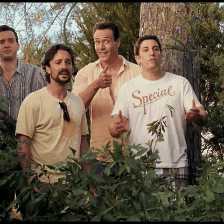

In [43]:
test_video = np.random.choice(test_df["path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

# test_video_paths = test_df["path"].values.tolist()
# test_labels = test_df["combination"].values
# for idx, path in enumerate(test_video_paths):
#     print(f"Truth label: {test_labels[idx]}")
#     test_frames = predict_action(path)
#     print("\n")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7327af42-8a03-4c46-b38e-e6931aa020f3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>